In [15]:
import numpy as np
# generate SEM
import sys
sys.path.append("..")
import scipy.stats as scistats
from notears.notears.notears import linear
from notears.notears.notears import utils
import helper.helper as h
import helper.methods as m
from timeit import default_timer as timer
from importlib import reload  # Python 3.4+
reload(linear)
import matplotlib.pyplot as plt

In [24]:
reload(m)

<module 'helper.methods' from '..\\helper\\methods.py'>

In [2]:
utils.set_random_seed(1)

n, d, s0, graph_type, sem_type = 50, 5, 5, 'ER', 'gauss'
print(f"SEM based on a graph on {d} nodes and {s0} edges, {n} samples.")

B_true = utils.simulate_dag(d, s0, graph_type)
print(f"Original Adjacency Matrix:\n{B_true}.\n")

W_true = utils.simulate_parameter(B_true)
print(f"Original WAM:\n{np.round(W_true, 1)}.\n")

X = utils.simulate_linear_sem(W_true, n, sem_type)

W_est, h_val = linear.notears_linear(X, lambda1=0.1, loss_type='l2-var', verbose = False)
print(f"Estimated WAM:\n{np.round(W_est, 1)}.\n")

acc = utils.count_accuracy(B_true, W_est != 0)
print(acc)

SEM based on a graph on 5 nodes and 5 edges, 50 samples.
Original Adjacency Matrix:
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]].

Original WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5 -1.9]
 [-1.9  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.1]
 [ 0.   0.  -0.9  0.   0. ]].

Estimated WAM:
[[ 0.   0.   0.   0.   0. ]
 [ 2.3  0.  -0.4  0.   0.4]
 [-0.6  0.   0.   0.   0. ]
 [-1.1  0.   0.   0.   0. ]
 [ 0.3  0.   0.   0.   0. ]].

{'fdr': 0.6666666666666666, 'tpr': 0.4, 'fpr': 0.8, 'shd': 7, 'nnz': 6}


In [28]:
Ps = range(50, 61)

T = 1000

r_NT = [[[] for _ in range(5)] for _ in range(len(Ps))]
r_OMP = [[[] for _ in range(5)] for _ in range(len(Ps))]

In [13]:
# numer of iterations
iters = 50

# number of different node sizes to try
for i, p in enumerate(Ps):
    
    print(f"{p}:", end = "\t")
    
    graph_type, sem_type = 'ER', 'gauss'
    s0 = int(min(2 * p, p * (p - 1) / 2))
    
    # number of iterations, more accurate results
    for j in range(iters):
        print(j, end = "\t")
    
        B_true = utils.simulate_dag(p, s0, graph_type)
        W_true = utils.simulate_parameter(B_true)
        X = utils.simulate_linear_sem(W_true, T, sem_type)
        
#         ## NOTEARS
#         notears_timer = timer()
#         W_est, h_val = linear.notears_linear(X, lambda1=0.0, loss_type='l2', verbose = False, w_threshold = 0.30)
#         r_NT[i][0].append(timer() - notears_timer)
        
#         # get accuracy
#         acc = utils.count_accuracy(B_true, W_est != 0)
    
#         # append results
#         r_NT[i][1].append(acc['tpr'])
#         r_NT[i][2].append(acc['fdr'])
#         r_NT[i][3].append(acc['shd'])
#         r_NT[i][4].append(h.MSE(W_est, X, is_sem = True))

        try:
            omp_timer = timer()
            W, r = m._K_OMP(X, X, F = [i * (p + 1) for i in range(p)], normalize = True, tol = 0)
            W[np.abs(W) <= 0.3] = 0
            r_OMP[i][0].append(timer() - omp_timer)

            acc = utils.count_accuracy(B_true, W != 0)

            r_OMP[i][1].append(acc['tpr'])
            r_OMP[i][2].append(acc['fdr'])
            r_OMP[i][3].append(acc['shd'])
            r_OMP[i][4].append(h.MSE(W, X, is_sem = True))
            
        except np.linalg.LinAlgError:
            print("Linalg Error. Retry")
            X_error = X.copy()
            j -= 1

# #         B_true = utils.simulate_dag(p, s0, graph_type)
# #         W_true = utils.simulate_parameter(B_true)
# #         X = utils.simulate_linear_sem(W_true, T, sem_type)

    np.savetxt(f"r_OMP_{p}.txt", r_OMP[i])
#     np.savetxt(f"r_NT_{p}.txt", r_NT[i])
    
    print()

21:	0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	29	30	31	32	33	34	35	36	37	38	39	40	41	42	43	44	45	46	47	48	49	50	51	52	53	54	55	56	57	58	59	60	61	62	63	64	65	66	67	68	69	70	71	72	73	74	75	76	77	78	79	80	81	82	83	84	85	86	87	88	89	90	91	92	93	94	95	96	97	98	99	100	101	102	103	104	105	106	107	108	109	110	111	112	113	114	115	116	117	118	119	120	121	122	123	124	125	126	127	128	129	130	131	132	133	134	135	136	137	138	139	140	141	142	143	144	145	146	147	148	149	150	151	152	153	154	155	156	157	158	159	160	161	162	163	164	165	166	167	168	169	170	171	172	173	174	175	176	177	178	179	180	181	182	183	184	185	186	187	188	189	190	191	192	193	194	195	196	197	198	199	200	201	202	203	204	205	206	207	208	209	210	211	212	213	214	215	216	217	218	219	220	221	222	223	224	225	226	227	228	229	230	231	232	233	Linalg Error. Retry
234	235	236	237	238	239	240	Linalg Error. Retry
241	242	243	244	245	246	247	248	249	250	251	252	253	254	255	256	257	258	259	260	261	262	263	264	265	26

KeyboardInterrupt: 

In [25]:
print(m._K_OMP(X_error, X_error, F = [i * (p + 1) for i in range(p)], normalize = True, tol = 0, verbose = True))

[8]
Iteration 1.

Gains:
[[-1.000000e+00  9.466600e+01  2.582200e+01  4.410000e-01  5.569400e+01
   4.820790e+02  4.214300e+01  2.473668e+03  2.242898e+03  1.713558e+03
   5.028000e+01  4.812700e+01  9.860000e-01  1.097000e+00  1.040000e-01
   1.100153e+03  7.927910e+02  4.861000e+00  1.098000e+00  1.494080e+02
   1.551120e+02]
 [ 7.238400e+01 -1.000000e+00  2.219700e+01  2.840000e-01  4.843900e+01
   5.400380e+02  4.189700e+01  2.796026e+03  2.572960e+03  1.892554e+03
   5.061100e+01  4.096000e+01  2.990000e-01  1.718000e+00  1.279100e+01
   1.209213e+03  8.862870e+02  2.075300e+01  1.880700e+01  1.659830e+02
   1.734980e+02]
 [ 6.745000e+01  7.583000e+01 -1.000000e+00  8.640000e-01  5.146000e+01
   4.288260e+02  5.226600e+01  2.190229e+03  1.993856e+03  1.525464e+03
   6.524000e+01  6.050600e+01  1.924000e+00  1.418000e+00  5.200000e-02
   9.967090e+02  7.092910e+02  4.614000e+00  1.123000e+00  1.342660e+02
   1.400760e+02]
 [ 1.153000e+00  9.710000e-01  8.650000e-01 -1.000000e+00  1

[9]
Iteration 13.

Gains:
[[-1.00000e+00  9.46660e+01  2.58220e+01  4.41000e-01  5.56940e+01
   1.98850e+01  4.21430e+01  4.04080e+01  3.73830e+01  2.26330e+01
   5.02800e+01  4.81270e+01  9.86000e-01  1.09700e+00  1.04000e-01
   9.88000e-01  2.03000e-01  4.86100e+00  1.09800e+00  1.49408e+02
   1.55112e+02]
 [ 7.23840e+01 -1.00000e+00  2.21970e+01  2.84000e-01  4.84390e+01
   2.65670e+01  4.18970e+01  4.69100e+00  2.37580e+01  2.21200e+00
   5.06110e+01  4.09600e+01  2.99000e-01  1.71800e+00  1.27910e+01
   6.95100e+00  1.59200e+00  2.07530e+01  1.88070e+01  1.65983e+02
   1.73498e+02]
 [ 6.74500e+01  7.58300e+01 -1.00000e+00  8.64000e-01  5.14600e+01
   1.34720e+01  5.22660e+01  2.71490e+01  4.62580e+01  1.26330e+01
   6.52400e+01  6.05060e+01  1.92400e+00  1.41800e+00  5.20000e-02
   1.64390e+01  4.25700e+00  4.61400e+00  1.12300e+00  1.34266e+02
   1.40076e+02]
 [ 1.15300e+00  9.71000e-01  8.65000e-01 -1.00000e+00  1.53900e+00
   3.66100e+00  4.56500e+00  3.51600e+00  4.51000e+00  


Gains:
[[-1.00000e+00  9.46660e+01  2.58220e+01  4.41000e-01  5.56940e+01
   1.98850e+01  4.21430e+01  4.04080e+01  1.94000e-01  2.26330e+01
   5.02800e+01  4.81270e+01  9.86000e-01  1.09700e+00  1.04000e-01
   9.88000e-01  2.03000e-01  4.86100e+00  1.09800e+00  6.22100e+00
   3.43400e+00]
 [ 7.23840e+01 -1.00000e+00  2.21970e+01  2.84000e-01  4.84390e+01
   2.65670e+01  4.18970e+01  4.69100e+00  1.76470e+01  2.21200e+00
   5.06110e+01  4.09600e+01  2.99000e-01  1.71800e+00  1.27910e+01
   6.95100e+00  1.59200e+00  2.07530e+01  1.88070e+01  0.00000e+00
   1.61000e+00]
 [ 6.74500e+01  7.58300e+01 -1.00000e+00  8.64000e-01  5.14600e+01
   1.34720e+01  5.22660e+01  2.71490e+01  1.26520e+01  1.26330e+01
   6.52400e+01  6.05060e+01  1.92400e+00  1.41800e+00  5.20000e-02
   1.64390e+01  4.25700e+00  4.61400e+00  1.12300e+00  1.95710e+01
   1.06700e+00]
 [ 1.15300e+00  9.71000e-01  8.65000e-01 -1.00000e+00  1.53900e+00
   3.66100e+00  4.56500e+00  3.51600e+00  1.07700e+00  1.27310e+01
   2.5


Beta_31:
[[ 0.     1.128  0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     1.513
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -1.644  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   1.297  0.     0.     0.    

Iteration 40.

Gains:
[[-1.0000e+00  0.0000e+00  2.5822e+01  4.4100e-01 -1.0000e+00  1.9885e+01
   1.2800e-01  1.3085e+01  3.3250e+00  2.2633e+01  4.4850e+00  5.1100e-01
   9.8600e-01  1.0970e+00  1.0400e-01  9.8800e-01  2.0300e-01  1.4000e+00
   1.0980e+00  6.2210e+00  3.4340e+00]
 [-1.0000e+00 -1.0000e+00  2.2197e+01  2.8400e-01  1.2880e+01  2.6567e+01
   5.7810e+00  5.2650e+00  1.4919e+01  2.2120e+00  5.0680e+00  8.5000e-01
   2.9900e-01  1.7180e+00  1.2791e+01  6.9510e+00  1.5920e+00  1.0050e+00
   1.8807e+01  0.0000e+00  1.6100e+00]
 [ 9.8000e-01  2.6800e-01 -1.0000e+00  8.6400e-01  0.0000e+00  1.3472e+01
   0.0000e+00  3.2180e+00  1.2694e+01  1.2633e+01  1.4100e+00  0.0000e+00
   1.9240e+00  1.4180e+00  5.2000e-02  1.6439e+01  4.2570e+00  5.3400e-01
   1.1230e+00  1.9571e+01  1.0670e+00]
 [ 8.3500e-01  2.2720e+00  8.6500e-01 -1.0000e+00  2.9250e+00  3.6610e+00
   3.1580e+00  1.6200e-01  1.3190e+00  1.2731e+01  3.2445e+01  3.0800e-01
   2.3100e-01  1.0400e-01  1.4040e+00  6.5880e+


[1, 13, 6]
Iteration 48.

Gains:
[[-1.0000e+00  0.0000e+00  2.5822e+01  4.4100e-01 -1.0000e+00  1.3259e+01
   1.2800e-01  1.3085e+01  3.3250e+00  1.1234e+01  6.5350e+00  5.1100e-01
   9.8600e-01  1.0970e+00  1.0400e-01  9.8800e-01  1.7100e+00  1.4000e+00
   9.3700e-01  5.8330e+00  3.4340e+00]
 [-1.0000e+00 -1.0000e+00  2.2197e+01  2.8400e-01  1.2880e+01  1.8516e+01
   5.7810e+00  5.2650e+00  1.4919e+01  4.0070e+00  6.3790e+00  8.5000e-01
   2.9900e-01  1.7180e+00 -1.0000e+00  6.9510e+00  2.1610e+00  1.0050e+00
   8.7700e-01  0.0000e+00  1.6100e+00]
 [ 9.8000e-01  4.7100e-01 -1.0000e+00  8.6400e-01  0.0000e+00  6.9210e+00
   0.0000e+00  3.2180e+00  1.2694e+01  2.5980e+00  2.5100e+00  0.0000e+00
   1.9240e+00  1.4180e+00  5.2000e-02  1.6439e+01  2.9970e+00  5.3400e-01
   1.2030e+00  1.9804e+01  1.0670e+00]
 [ 8.3500e-01  1.8900e-01  8.6500e-01 -1.0000e+00  2.9250e+00  3.7450e+00
   3.1580e+00  1.6200e-01  1.3190e+00  1.4420e+01  0.0000e+00  3.0800e-01
   2.3100e-01  1.0400e-01  1.4040e+


Beta_54:
[[ 0.     1.13   0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     1.215
   0.   ]
 [ 0.     0.     0.     0.    -1.602  0.     1.627  0.     0.     0.
   0.    -1.884  0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -1.016  0.     0.     0.     0.     0.    -1.097  0.     0.     0.
   0.   ]
 [ 1.292  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -1.645  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   1.38   0.     0.     0.    


Beta_62:
[[ 0.     1.13   0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     1.215
   0.   ]
 [ 0.     0.     0.     0.    -1.602  0.     1.627  0.     0.     0.
   0.    -1.884  0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -1.016  0.     0.     0.     0.     0.    -1.098  0.     0.     0.
   0.   ]
 [ 1.292  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -1.643  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   1.38   0.     0.     0.    


Residual Squared: [1004.36705421  981.13409769 1031.8525396  1030.54431516  969.75161864
 1553.88050915 1188.82479527 2418.51436931 5771.33581008 2874.88054305
 3302.69641421 1033.82303951 1071.41645658 1073.89133253  951.67379746
  892.48117562 2164.91828303 1052.75642371  931.5875752  1969.59333925
  480.9522891 ].


[16, 18, 12, 13, 14, 6, 10, 3]
Iteration 70.

Gains:
[[-1.0000e+00  0.0000e+00 -1.0000e+00  4.4100e-01 -1.0000e+00  1.5340e+00
   1.2800e-01  1.3085e+01  2.0270e+00  1.1234e+01  6.5350e+00  5.1100e-01
   9.8600e-01  1.0970e+00  1.0400e-01  1.2500e-01  3.3500e-01  1.4000e+00
   9.3700e-01  9.1900e-01  3.4340e+00]
 [-1.0000e+00 -1.0000e+00 -1.0000e+00  2.8400e-01  1.2880e+01  0.0000e+00
   5.7810e+00  5.2650e+00  4.9570e+00  4.0070e+00  6.3790e+00  8.5000e-01
   2.9900e-01  1.7180e+00 -1.0000e+00  1.3600e-01  1.4180e+00  1.0050e+00
   8.7700e-01  0.0000e+00  1.6100e+00]
 [ 9.8000e-01  4.7100e-01 -1.0000e+00  8.6400e-01  0.0000e+00  7.1210e+00
   0.0000e+00  3.2180e+00  1.


Beta_79:
[[ 0.     1.13   0.     0.     0.     0.     0.    -1.153  0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     1.533  0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     1.215
   0.   ]
 [ 0.     0.     0.     0.    -1.602  0.     1.626  0.     0.     0.
   0.    -1.884  0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.9    0.45
  -1.04   0.     0.     0.     0.     0.    -0.873  0.     0.     0.
   0.   ]
 [ 1.292  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -1.616  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    -2.067  0.
   1.852  0.     0.     0.  


Beta_87:
[[ 0.     1.13   0.     0.     0.     0.     0.    -1.153  0.    -1.111
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     1.533  0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     1.215
   0.   ]
 [ 0.     0.     0.     0.    -1.602  0.     1.626  0.     0.     0.
   0.    -1.884  0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.9    0.412
  -1.04   0.     0.     0.     0.     0.    -0.873  0.     0.     0.
   0.   ]
 [ 1.292  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -1.616  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    -2.067  0.
   1.852  0.     0.     

Iteration 95.

Gains:
[[-1.000e+00  0.000e+00 -1.000e+00  4.410e-01 -1.000e+00  7.310e-01
   1.950e-01  0.000e+00  3.309e+00  0.000e+00  9.690e-01  5.110e-01
   9.860e-01  1.097e+00  1.040e-01  1.250e-01  3.350e-01  1.400e+00
   9.370e-01  9.190e-01  2.376e+00]
 [-1.000e+00 -1.000e+00 -1.000e+00  2.840e-01 -1.000e+00  0.000e+00
   5.700e-02  1.380e-01  3.183e+00  5.720e-01  0.000e+00  8.500e-01
   2.990e-01  1.718e+00 -1.000e+00  1.360e-01  1.418e+00  1.005e+00
   8.770e-01  0.000e+00  2.830e-01]
 [ 9.800e-01  4.710e-01 -1.000e+00  8.640e-01  0.000e+00  4.173e+00
   0.000e+00  3.770e-01  2.009e+00  1.779e+00  6.990e-01  0.000e+00
   1.924e+00  1.418e+00  5.200e-02  2.920e-01  1.494e+00  5.340e-01
   1.203e+00  7.020e-01  1.300e-02]
 [ 8.350e-01  1.890e-01  8.650e-01 -1.000e+00  2.925e+00  8.458e+00
   2.516e+00  1.071e+00  0.000e+00  0.000e+00  0.000e+00  3.080e-01
   2.310e-01  1.040e-01  1.404e+00  9.980e-01  0.000e+00  8.510e-01
   4.800e-02  1.630e+00  7.422e+00]
 [ 0.000e+00  8.30


Residual Squared: [1004.36705421  981.13409769 1031.8525396  1030.54431516  969.75161864
 1252.43322642  989.51419669 1152.54189606 5182.69278184 1469.69403276
 1815.82056762 1033.82303951 1071.41645658 1073.89133253  951.67379746
  892.48117562 2164.91828303 1052.75642371  931.5875752  1969.59333925
  376.5447652 ].


[9, 13, 3]
Iteration 103.

Gains:
[[-1.000e+00  0.000e+00 -1.000e+00  4.410e-01 -1.000e+00  8.130e-01
   1.950e-01  0.000e+00  3.309e+00  0.000e+00  8.970e-01  5.110e-01
   9.860e-01  1.097e+00  1.040e-01  1.250e-01  3.350e-01  1.400e+00
   9.370e-01  9.190e-01  2.376e+00]
 [-1.000e+00 -1.000e+00 -1.000e+00  2.840e-01 -1.000e+00  0.000e+00
   5.700e-02  1.380e-01  3.183e+00  5.720e-01  0.000e+00  8.500e-01
   2.990e-01  1.718e+00 -1.000e+00  1.360e-01  1.418e+00  1.005e+00
   8.770e-01  0.000e+00  2.830e-01]
 [ 9.800e-01  4.710e-01 -1.000e+00  8.640e-01  0.000e+00  3.380e+00
   0.000e+00  3.770e-01  2.009e+00  1.779e+00  3.830e-01  0.000e+00
   1.924e+00  1.418e+00  5.2


Beta_110:
[[ 0.     1.13   0.     0.     0.     0.     0.    -1.153  0.    -1.106
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     1.971  0.     0.     0.     0.
  -0.914  0.     0.     0.     0.     0.     0.     0.     0.     1.215
   0.   ]
 [ 0.     0.     0.     0.    -1.602  0.     1.626  0.     0.     0.
   0.    -1.884  0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.069  0.     0.     0.9    0.497
  -0.988  0.     0.     0.     0.     0.    -0.873  0.     0.     0.
   0.3  ]
 [ 1.292  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -1.616  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.    -1.013  0.     0.    -2.067  0.
   2.192  0.     0.    


Beta_118:
[[ 0.     1.13   0.     0.     0.     0.     0.    -1.153  0.852 -1.031
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     1.971  0.     0.    -1.726  0.
  -0.914  0.     0.     0.     0.     0.     0.     0.     0.     1.215
   0.   ]
 [ 0.     0.     0.     0.    -1.604  0.     1.624  0.     0.     0.
   0.    -1.884  0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.091  0.069  0.079  0.     0.527  0.585
  -0.988  0.     0.     0.     0.     0.    -0.717  0.     0.     0.
   0.294]
 [ 1.292  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -1.638  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.    -1.013  0.     0.    -1.043 -0.249
   2.192  0.     0. 

[5, 3, 12, 13, 10, 6, 19]
Iteration 127.

Gains:
[[-1.     0.    -1.     0.441 -1.     0.211  0.284  0.     0.     0.
   0.897  0.511  0.432  0.217  0.104  0.125  0.816  1.4    0.937  0.919
   1.009]
 [-1.    -1.    -1.     0.284 -1.     0.     0.015  0.138  0.     0.554
   0.     0.85   0.159  0.6   -1.     0.136  0.37   1.005  0.877  0.
   0.15 ]
 [ 0.98   0.471 -1.     0.864  0.     0.173  0.     0.377  0.308  0.004
   0.383  0.     0.177  0.234  0.052  0.292  0.681  0.534  1.203  0.702
   0.896]
 [ 0.835  0.189  0.865 -1.     0.     0.     0.     1.071  0.     0.
   0.     0.308  0.273  0.14   1.404  0.998  0.     0.851  0.048  1.63
   0.   ]
 [ 0.     0.083 -1.    -1.    -1.     0.216  0.756  0.279  0.249  0.49
   1.021  0.141  0.269  0.377  0.444  0.134  0.29   0.817  1.051  0.625
   1.018]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.     0.358  1.738  0.329
  -1.     0.613 -1.    -1.    -1.     0.04   0.     0.979  0.967 -1.
   0.435]
 [ 0.021  0.788 -1.    -1.     0.93   0. 


Gains:
[[-1.     0.    -1.     0.436 -1.     0.211  0.284  0.     0.     0.
   0.281  0.511  0.432  0.217  0.104  0.125  0.095  1.4    0.937  0.478
   1.009]
 [-1.    -1.    -1.     0.322 -1.     0.     0.015  0.267  0.     0.554
   0.     0.85   0.159  0.6   -1.     0.136  1.001  1.005  0.877  0.
   0.15 ]
 [ 0.98   0.471 -1.     0.862  0.     0.173  0.     0.225  0.38   0.004
   0.054  0.     0.177  0.234  0.052  0.292  0.944  0.534  1.203  0.203
   0.896]
 [ 0.835  0.189  0.865 -1.     0.     0.     0.     1.103  0.     0.
   0.     0.308  0.273  0.14  -1.     0.998  0.     0.851  0.048  0.
   0.   ]
 [ 0.     0.083 -1.    -1.    -1.     0.216  0.756  0.195  0.481  0.49
   0.495  0.141  0.269  0.377  0.444  0.134  1.178  0.817  1.051  0.111
   1.018]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.     0.377  0.     0.329
  -1.     0.613 -1.    -1.    -1.     0.04   0.     0.979  0.967 -1.
   0.435]
 [ 0.021  0.788 -1.    -1.     0.93   0.    -1.     0.769  0.     0.
   0.     0.406


Residual Squared: [1002.32420647  981.13409769 1031.8525396  1028.41124903  961.18922
  955.15459407  983.1643217  1149.6177202  2828.57322636 1410.59579865
 1813.27975323 1033.82303951 1061.94296087 1070.39215592  951.67379746
  892.48117562 1751.04486371 1050.79298527  931.5875752  1960.36358118
  232.23697063].


Iteration 140.

Gains:
[[-1.     0.    -1.     0.436 -1.     0.211  0.284  0.     0.     0.
   0.281  0.511  0.432 -1.     0.104  0.125  0.045  0.     0.937  0.478
   1.009]
 [-1.    -1.    -1.     0.322 -1.     0.     0.015  0.267  0.     0.554
   0.     0.85   0.159  0.6   -1.     0.136  0.898  0.212  0.877  0.
   0.15 ]
 [ 0.975  0.471 -1.     0.862  0.     0.173  0.     0.225  0.38   0.004
   0.054  0.     0.177  0.234  0.052  0.292  0.602  0.591  1.203  0.203
   0.896]
 [ 0.833  0.189  0.865 -1.     0.     0.     0.     1.103  0.     0.
   0.     0.308  0.273  0.14  -1.     0.998  0.     0.869  0.048  0.
   0.   ]
 [ 0.     0.083 -1.    -1.    -1.     0.216  0.756  0.

Iteration 146.

Gains:
[[-1.000e+00  0.000e+00 -1.000e+00  4.360e-01 -1.000e+00  2.110e-01
   2.840e-01  0.000e+00  0.000e+00  0.000e+00  2.810e-01  5.110e-01
   4.320e-01 -1.000e+00 -1.000e+00  1.250e-01  4.500e-02  0.000e+00
   9.370e-01  4.780e-01  1.334e+00]
 [-1.000e+00 -1.000e+00 -1.000e+00  3.220e-01 -1.000e+00  0.000e+00
   1.500e-02  1.650e-01  0.000e+00  5.540e-01  0.000e+00  8.500e-01
   1.590e-01  6.000e-01 -1.000e+00  1.360e-01  8.980e-01  2.120e-01
   8.770e-01  0.000e+00  6.940e-01]
 [ 9.610e-01  4.710e-01 -1.000e+00  8.620e-01  0.000e+00  1.730e-01
   0.000e+00  2.000e-01  3.800e-01  4.000e-03  5.400e-02  0.000e+00
   1.770e-01  2.340e-01  5.200e-02  2.920e-01  6.020e-01  5.910e-01
   1.203e+00  2.030e-01  3.200e-01]
 [ 8.950e-01  1.890e-01  8.650e-01 -1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  3.080e-01
   2.730e-01  1.400e-01 -1.000e+00  9.980e-01  0.000e+00  8.690e-01
   4.800e-02  0.000e+00  0.000e+00]
 [ 0.000e+00  8.3


[9, 6, 3]
Iteration 154.

Gains:
[[-1.     0.    -1.     0.436 -1.     0.211  0.284  0.     0.     0.
   0.281  0.511  0.432 -1.    -1.     0.125  0.045  0.     0.03   0.489
   0.   ]
 [-1.    -1.    -1.     0.322 -1.     0.     0.015  0.165  0.     0.572
   0.     0.85   0.159 -1.    -1.     0.136  0.898  0.212  0.046  0.
   0.448]
 [ 0.961  0.489 -1.     0.862  0.     0.173  0.     0.2    0.38   0.453
   0.054  0.     0.177  0.241  0.052  0.292  0.602  0.591  0.     0.188
   0.186]
 [ 0.895  0.194  0.865 -1.     0.     0.     0.     0.     0.     0.
   0.     0.308  0.273  0.188 -1.     0.998  0.     0.869  0.081  0.
   0.   ]
 [ 0.     0.108 -1.    -1.    -1.     0.216  0.756  0.08   0.481  0.354
   0.495  0.141  0.269 -1.     0.444  0.134  0.     0.478  0.021  0.121
   0.012]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.     0.379  0.     0.332
  -1.     0.613 -1.    -1.    -1.     0.04   0.     0.238  0.047 -1.
   0.314]
 [ 0.263  0.79  -1.    -1.     0.935  0.    -1.     0.018


Beta_162:
[[ 0.     1.13   0.     0.     0.     0.     0.    -1.17   0.876 -1.034
   0.     0.     0.     0.     0.     0.     0.    -0.017  0.     0.
   0.158]
 [ 0.     0.     0.     0.     0.     1.971  0.     0.    -0.705  0.
  -0.905  0.     0.     0.     0.     0.    -0.557  0.     0.     1.214
   0.   ]
 [-0.112  0.     0.     0.    -1.522  0.     1.624  0.     0.     0.
   0.    -1.884  0.     0.     0.     0.     0.     0.     0.037  0.
   0.   ]
 [ 0.     0.     0.     0.     0.096  0.069  0.079 -0.049  0.191  0.634
  -0.99   0.     0.     0.     0.     0.032 -0.587  0.     0.    -0.055
   0.389]
 [ 1.242  0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.    -0.098  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.    -1.552  0.
   0.     0.     0.     0.     0.     0.    -1.13   0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.    -0.05  -1.013  0.     0.    -2.315 -0.306
   2.194  0.    -


Residual Squared: [ 997.03233043  978.63829614 1031.10435617 1028.41124903  956.53545904
  952.30249438  983.1643217  1144.92347569 2819.71967913 1407.83674525
 1810.70019065 1033.82303951 1061.94296087 1069.26327854  951.67379746
  891.47050668 1696.17990389 1050.03720815  930.14019893 1957.69527491
  198.0041118 ].


[16, 18, 12, 13, 14, 6, 10, 3, 0, 1, 5, 17, 19]
Iteration 171.

Gains:
[[-1.     0.    -1.     0.436 -1.     0.068  0.284  0.     0.     0.
   0.281  0.511  0.432 -1.    -1.     0.135  0.645  0.     0.03   0.181
   0.   ]
 [-1.    -1.    -1.     0.322 -1.     0.    -1.     0.165  0.     0.572
   0.    -1.     0.159 -1.    -1.     0.165  0.     0.218  0.046  0.
   0.448]
 [ 0.     0.021 -1.    -1.     0.     0.12   0.     0.2    0.339  0.453
   0.038  0.     0.177  0.241  0.052  0.276  0.623  0.624  0.     0.324
   0.186]
 [ 0.718  0.308  0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.308  0.273  0.188 -1.     0.     0.     0.     0.081  0.
   0.   ]
 [ 

Iteration 181.

Gains:
[[-1.     0.    -1.    -1.    -1.     0.068  0.283  0.     0.     0.
   0.281  0.511  0.432 -1.    -1.     0.175  0.652  0.     0.03   0.181
   0.   ]
 [-1.    -1.    -1.     0.322 -1.     0.    -1.     0.165  0.     0.125
   0.    -1.     0.159 -1.    -1.     0.059  0.     0.226  0.046  0.
   0.448]
 [ 0.     0.021 -1.    -1.     0.     0.12   0.     0.2    0.182  0.541
   0.038  0.     0.177  0.241  0.052  0.249  0.34   0.191  0.     0.324
   0.186]
 [ 0.     0.308  0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.308  0.273  0.188 -1.     0.     0.     0.     0.081  0.
   0.   ]
 [ 0.     0.051 -1.    -1.    -1.     0.216 -1.     0.08   0.22   0.187
   0.502  0.141 -1.    -1.     0.444  0.223  0.     0.326  0.021  0.113
   0.012]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.     0.379  0.     0.37
  -1.    -1.    -1.    -1.    -1.     0.025  0.     0.172  0.047 -1.
   0.314]
 [ 0.539  0.    -1.    -1.     0.     0.    -1.     0.018  0.     0.



Residual Squared: [ 996.51025655  978.63829614 1031.10435617 1028.41124903  956.53545904
  952.30249438  982.66246514 1143.66129167 2737.23242075 1357.46874558
 1810.70019065 1033.82303951 1061.61100741 1069.26327854  951.67379746
  888.60187988 1687.84729    1048.75201863  929.7636076  1957.69527491
  198.0041118 ].


[16, 14, 3, 0, 13, 10, 6, 12, 11, 19, 2]
Iteration 190.

Gains:
[[-1.     0.    -1.    -1.    -1.     0.068  0.283  0.     0.     0.
   0.281  0.511  0.44  -1.    -1.     0.175  0.     0.     0.029  0.181
   0.   ]
 [-1.    -1.    -1.     0.322 -1.     0.    -1.     0.159  0.     0.125
   0.    -1.     0.175 -1.    -1.     0.059  0.     0.231  0.041  0.
   0.448]
 [ 0.     0.021 -1.    -1.     0.     0.12   0.     0.175  0.182  0.541
   0.038  0.     0.166  0.241  0.052  0.249  0.372  0.201  0.     0.324
   0.186]
 [ 0.     0.308  0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.308  0.27   0.188 -1.     0.     0.     0.     0.077  0.
   0.   ]
 [ 0.     

[16, 18, 12, 13, 14, 6, 10, 3, 0, 1, 5, 17, 19, 15, 11]
Iteration 197.

Gains:
[[-1.     0.    -1.    -1.    -1.     0.068 -1.     0.     0.     0.
   0.091 -1.     0.44  -1.    -1.     0.175  0.     0.     0.029  0.181
   0.   ]
 [-1.    -1.    -1.     0.322 -1.     0.    -1.     0.159  0.     0.123
   0.    -1.     0.175 -1.    -1.     0.059  0.     0.231  0.041  0.
   0.448]
 [ 0.     0.021 -1.    -1.     0.     0.12   0.     0.175  0.029  0.
   0.024  0.     0.166  0.241  0.052  0.249  0.372  0.201  0.     0.324
   0.186]
 [ 0.     0.308  0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.285  0.27   0.188 -1.     0.     0.     0.     0.077  0.
   0.   ]
 [ 0.     0.051 -1.    -1.    -1.     0.216 -1.     0.089  0.14   0.335
   0.     0.134 -1.    -1.     0.444  0.223  0.     0.329  0.011  0.113
   0.012]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.     0.364  0.     0.367
  -1.    -1.    -1.    -1.    -1.     0.025  0.     0.177  0.109 -1.
   0.314]
 [ 0.     0.   


Residual Squared: [ 994.14064034  978.63829614 1031.10435617 1028.41124903  956.53545904
  952.30249438  982.66246514 1016.44228137 2379.67008598 1354.72897978
 1807.83274421 1033.56586682 1061.61100741 1069.26327854  951.67379746
  888.60187988 1687.84729    1048.75201863  929.7636076  1957.69527491
  188.70864612].


[8, 14, 0, 13, 10, 3, 18, 16, 12, 6]
Iteration 205.

Gains:
[[-1.000e+00  0.000e+00 -1.000e+00 -1.000e+00 -1.000e+00  6.800e-02
  -1.000e+00  0.000e+00  0.000e+00  0.000e+00  9.100e-02 -1.000e+00
  -1.000e+00 -1.000e+00 -1.000e+00  1.750e-01  0.000e+00  0.000e+00
   2.900e-02  1.810e-01  0.000e+00]
 [-1.000e+00 -1.000e+00 -1.000e+00  3.220e-01 -1.000e+00  0.000e+00
  -1.000e+00  1.336e+00  0.000e+00  1.230e-01  0.000e+00 -1.000e+00
   1.750e-01 -1.000e+00 -1.000e+00  5.900e-02  0.000e+00  2.310e-01
   4.100e-02  0.000e+00  0.000e+00]
 [ 0.000e+00  2.100e-02 -1.000e+00 -1.000e+00  0.000e+00  1.200e-01
   0.000e+00  1.557e+00  2.480e-01  0.000e+00  2.400e-02  0.000e+00
  


Beta_211:
[[ 0.     1.142  0.     0.     0.     0.     0.    -0.815  0.497 -1.173
   0.     0.     0.     0.     0.     0.     0.13  -0.028  0.     0.
   0.112]
 [ 0.     0.     0.     0.     0.     1.963  0.     0.075 -0.241  0.
  -0.926  0.     0.     0.     0.     0.    -0.625  0.     0.     1.214
   0.189]
 [-0.221  0.     0.     0.    -1.524  0.     1.625  0.     0.     0.165
   0.    -1.884  0.     0.     0.     0.     0.117  0.     0.037  0.
   0.   ]
 [-0.025  0.     0.027  0.     0.096  0.07   0.078  0.072  0.136  0.762
  -0.994  0.     0.     0.     0.     0.031 -0.589  0.028  0.    -0.055
   0.429]
 [ 1.245  0.     0.     0.     0.     0.     0.     0.     0.     0.066
   0.062  0.     0.     0.     0.     0.    -0.137  0.     0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.699 -1.744  0.287
   0.     0.     0.     0.     0.     0.    -1.127  0.     0.     0.
   0.   ]
 [ 0.035  0.026  0.     0.    -0.05  -0.994  0.    -1.039 -1.65  -0.428
   2.195


Beta_218:
[[ 0.     1.146  0.     0.     0.     0.     0.    -0.815  0.497 -1.126
   0.     0.     0.     0.     0.     0.     0.13  -0.054  0.     0.
   0.112]
 [ 0.     0.     0.     0.     0.     1.964  0.     0.075 -0.241 -0.25
  -0.926  0.     0.     0.     0.     0.    -0.625  0.     0.     1.212
   0.189]
 [-0.221  0.     0.     0.    -1.524  0.     1.625  0.     0.     0.159
   0.    -1.884  0.     0.     0.     0.     0.117  0.     0.037  0.
   0.   ]
 [-0.025  0.     0.027  0.     0.096  0.07   0.078  0.072  0.136  0.73
  -0.994  0.     0.     0.     0.     0.03  -0.589  0.027  0.    -0.054
   0.429]
 [ 1.245  0.     0.     0.     0.     0.     0.     0.     0.     0.063
   0.062  0.     0.     0.     0.     0.    -0.137  0.045  0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.699 -1.744  0.35
   0.     0.     0.     0.     0.     0.    -1.127  0.     0.     0.
   0.   ]
 [ 0.035  0.017  0.     0.    -0.05  -0.996  0.    -1.039 -1.65  -0.293
   2.195


Beta_227:
[[ 0.     1.147  0.     0.     0.     0.     0.    -0.815  1.149 -1.126
   0.     0.     0.     0.     0.     0.     0.13  -0.054  0.     0.054
   0.112]
 [ 0.     0.     0.     0.     0.     1.964  0.     0.075 -0.234 -0.251
  -0.926  0.     0.     0.     0.     0.    -0.625  0.     0.     1.18
   0.189]
 [-0.221  0.     0.     0.    -1.524  0.     1.625  0.     0.     0.158
   0.    -1.884  0.     0.     0.     0.     0.117  0.     0.037  0.098
   0.   ]
 [-0.025 -0.01   0.027  0.     0.096  0.07   0.078  0.072  0.1    0.729
  -0.994  0.     0.     0.     0.     0.03  -0.589  0.027  0.    -0.055
   0.429]
 [ 1.245  0.     0.     0.     0.     0.     0.     0.    -0.06   0.063
   0.062  0.     0.     0.     0.     0.    -0.137  0.045  0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.699 -1.749  0.35
   0.     0.     0.     0.     0.     0.    -1.127  0.     0.     0.
   0.   ]
 [ 0.035  0.019  0.     0.    -0.05  -0.996  0.    -1.039 -1.165 -0.291
 


Beta_234:
[[ 0.     1.148  0.     0.     0.     0.     0.    -0.815  1.149 -1.126
   0.     0.     0.     0.     0.     0.     0.13  -0.054  0.     0.054
   0.116]
 [ 0.     0.     0.     0.     0.     1.964  0.     0.075 -0.234 -0.251
  -0.926  0.     0.     0.     0.     0.    -0.625  0.     0.     1.18
   0.187]
 [-0.221  0.     0.     0.    -1.524  0.     1.625  0.     0.     0.158
   0.    -1.884  0.     0.     0.     0.     0.117  0.     0.037  0.098
   0.   ]
 [-0.025 -0.011  0.027  0.     0.096  0.07   0.078  0.072  0.1    0.729
  -0.994  0.009  0.009  0.     0.     0.03  -0.589  0.027  0.    -0.055
   0.429]
 [ 1.245  0.     0.     0.     0.     0.     0.     0.    -0.06   0.063
   0.062  0.     0.     0.     0.     0.    -0.137  0.045  0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.699 -1.749  0.35
   0.     0.     0.     0.     0.     0.    -1.127  0.     0.     0.
   0.   ]
 [ 0.035  0.019  0.     0.    -0.05  -0.996  0.    -1.039 -1.165 -0.291
 


Beta_242:
[[ 0.     1.148  0.     0.     0.     0.     0.    -0.815  1.149 -1.126
   0.     0.     0.     0.     0.     0.     0.13  -0.054  0.     0.054
   0.133]
 [ 0.     0.     0.     0.     0.     1.964  0.     0.075 -0.234 -0.251
  -0.926  0.     0.     0.     0.     0.    -0.625  0.     0.     1.18
  -0.181]
 [-0.221  0.     0.     0.    -1.524  0.     1.625  0.     0.     0.158
   0.    -1.884  0.     0.     0.    -0.066  0.117  0.     0.037  0.098
   0.   ]
 [-0.025 -0.011  0.027  0.     0.096  0.07   0.078  0.072  0.1    0.729
  -0.994  0.009  0.009  0.     0.     0.019 -0.589  0.026  0.    -0.055
   0.441]
 [ 1.245  0.     0.     0.     0.     0.     0.     0.    -0.06   0.063
   0.062  0.     0.     0.     0.    -0.038 -0.137  0.046  0.     0.
   0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.699 -1.749  0.35
   0.     0.     0.     0.     0.     0.    -1.127  0.     0.     0.
   0.254]
 [ 0.035  0.019  0.     0.    -0.05  -0.996  0.    -1.039 -1.165 -0.291
 


Residual Squared: [ 994.14064034  976.74638524 1031.10435617 1028.41124903  956.53545904
  949.09577249  982.395259    736.87951098 1890.36633847 1284.56601823
 1807.83274421 1033.48430637 1061.09536775 1068.99899169  951.67379746
  886.09368281 1686.23866104 1047.60346628  929.7636076  1955.00987701
  137.29120794].


Iteration 250.

Gains:
[[-1.     0.    -1.    -1.    -1.     0.128 -1.     0.     0.     0.
   0.091 -1.    -1.    -1.    -1.     0.09   0.     0.     0.029  0.
   0.   ]
 [-1.    -1.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.    -1.    -1.    -1.    -1.     0.044  0.    -1.    -1.     0.
   0.   ]
 [ 0.     0.125 -1.    -1.     0.     0.188  0.     0.     0.179  0.
   0.024  0.     0.     0.     0.052  0.     0.     0.076  0.     0.
   0.025]
 [ 0.     0.     0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.178 -1.     0.     0.     0.     0.077  0.
   0.   ]
 [ 0.     0.095 -1.    -1.    -1.     0.    -1.     0.087  0.  

[11, 14, 2, 3]
Iteration 258.

Gains:
[[-1.     0.    -1.    -1.    -1.     0.122 -1.     0.     0.     0.
   0.091 -1.    -1.    -1.    -1.     0.09   0.     0.     0.029  0.
   0.   ]
 [-1.    -1.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.    -1.    -1.    -1.    -1.     0.044  0.    -1.    -1.     0.
   0.   ]
 [ 0.     0.125 -1.    -1.     0.     0.     0.     0.     0.     0.
   0.024  0.     0.     0.     0.052  0.     0.     0.076  0.     0.
   0.025]
 [ 0.     0.     0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.178 -1.     0.     0.     0.     0.077  0.
   0.   ]
 [ 0.     0.095 -1.    -1.    -1.     0.    -1.     0.087  0.     0.
   0.     0.148 -1.    -1.    -1.     0.     0.     0.     0.011  0.145
   0.002]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.     0.     0.     0.
  -1.    -1.    -1.    -1.    -1.     0.     0.    -1.    -1.    -1.
   0.   ]
 [ 0.     0.    -1.    -1.     0.     0.    -1.     0.     0.     0.
  


Residual Squared: [ 994.14064034  976.74638524 1031.10435617 1028.41124903  956.41914298
  948.73976426  982.27213318  671.0039971  1890.04330518 1284.56601823
 1807.83274421 1033.48430637 1061.09536775 1068.96733182  951.67379746
  885.95403751 1686.23866104 1047.60346628  929.7636076  1954.81245465
  137.21332492].


Iteration 267.

Gains:
[[-1.     0.    -1.    -1.    -1.     0.122 -1.     0.     0.     0.
   0.091 -1.    -1.    -1.    -1.     0.093  0.     0.     0.029  0.
   0.   ]
 [-1.    -1.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.    -1.    -1.    -1.    -1.     0.041  0.    -1.    -1.     0.
   0.   ]
 [ 0.     0.125 -1.    -1.     0.     0.     0.     0.     0.     0.
   0.024  0.     0.     0.     0.052  0.     0.     0.076  0.     0.
   0.023]
 [ 0.     0.     0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.    -1.     0.     0.     0.     0.077  0.
   0.   ]
 [ 0.     0.095 -1.    -1.    -1.     0.    -1.     0.087  0.  

Gains:
[[-1.     0.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.091 -1.    -1.    -1.    -1.     0.093  0.     0.     0.034  0.
   0.   ]
 [-1.    -1.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.    -1.    -1.    -1.    -1.     0.041  0.    -1.    -1.     0.
   0.   ]
 [ 0.     0.    -1.    -1.     0.     0.     0.     0.     0.     0.
   0.024  0.     0.     0.     0.052  0.     0.     0.114  0.     0.
   0.023]
 [ 0.     0.     0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.    -1.     0.     0.     0.     0.079  0.
   0.   ]
 [ 0.     0.06  -1.    -1.    -1.     0.    -1.     0.086  0.     0.
   0.    -1.    -1.    -1.    -1.     0.     0.     0.     0.01   0.
   0.003]
 [-1.    -1.    -1.    -1.    -1.    -1.    -1.     0.     0.     0.
  -1.    -1.    -1.    -1.    -1.     0.001  0.    -1.    -1.    -1.
   0.   ]
 [ 0.     0.    -1.    -1.     0.     0.    -1.     0.     0.     0.
   0.    -1.     0.    -1.    -1.   


Residual Squared: [ 994.14064034  976.56564799 1031.10435617 1028.41124903  956.41914298
  948.49502808  982.27213318  549.09297143 1890.04330518 1284.56601823
 1807.69837671 1033.48430637 1061.05531587 1068.96733182  951.67379746
  885.66712183 1686.23866104 1047.43262403  929.67535092 1954.81245465
  137.21332492].


[4, 13, 14, 2, 3, 6, 12, 11, 18]
Iteration 283.

Gains:
[[-1.     0.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.    -1.    -1.    -1.    -1.     0.     0.     0.     0.036  0.
   0.   ]
 [-1.    -1.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.    -1.    -1.    -1.    -1.     0.     0.    -1.    -1.     0.
   0.   ]
 [ 0.     0.    -1.    -1.     0.     0.     0.     0.     0.     0.
   0.019  0.     0.     0.     0.052  0.     0.     0.     0.     0.
   0.023]
 [ 0.     0.     0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.    -1.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.    -1.    -1.    

Beta_290:
[[ 0.000e+00  1.140e+00  0.000e+00  0.000e+00  0.000e+00 -2.400e-02
   0.000e+00 -5.210e-01  1.149e+00 -1.126e+00  1.800e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00 -2.300e-02  1.310e-01 -5.500e-02
   0.000e+00  6.500e-02  1.780e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.967e+00
   0.000e+00  7.500e-02 -2.340e-01 -2.510e-01 -9.350e-01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  2.500e-02 -6.260e-01  0.000e+00
   0.000e+00  1.180e+00 -1.800e-01]
 [-2.210e-01 -3.200e-02  0.000e+00  0.000e+00 -1.545e+00  5.700e-02
   1.656e+00  3.600e-02 -5.600e-02  1.570e-01  0.000e+00 -1.884e+00
  -3.600e-02  3.400e-02  0.000e+00 -9.000e-02  1.160e-01 -3.600e-02
   5.400e-02  8.700e-02 -1.200e-02]
 [-2.500e-02 -1.100e-02  2.700e-02  0.000e+00  9.600e-02  6.700e-02
   7.800e-02  3.400e-02  1.010e-01  7.290e-01 -9.940e-01  9.000e-03
   8.000e-03  6.000e-03  0.000e+00  2.200e-02 -5.890e-01  2.600e-02
  -2.000e-03 -5.400e-02  4.050e-01]
 [ 1.245e+00  9.000e-03  0.000


Residual Squared: [ 994.13109842  976.56564799 1031.10412782 1028.41124903  956.41360788
  948.49502808  982.27213318  549.09297143 1890.04330518 1284.54451961
 1807.69470228 1033.48430637 1061.05531587 1068.96733182  951.67379746
  885.06297456 1686.21709138 1047.43262403  929.67535092 1954.81080362
  135.01551772].


[6, 12, 3, 19, 1, 13, 14, 18, 4, 11, 0, 2, 17]
Iteration 299.

Gains:
[[-1.     0.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.    -1.    -1.    -1.    -1.     0.     0.     0.    -1.     0.
   0.   ]
 [-1.    -1.    -1.    -1.    -1.     0.    -1.     0.     0.     0.
   0.    -1.    -1.    -1.    -1.     0.     0.    -1.    -1.     0.
   0.   ]
 [ 0.     0.    -1.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.    -1.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.     0.    -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.    -1.     0.     0.     0.     0.     0.
   0.   ]
 [ 0.     0.    


Residual Squared: [ 994.13109842  976.56564799 1031.10412782 1028.41124903  956.41360788
  948.49502808  982.27213318  549.09297143 1890.04330518 1284.54451961
 1807.69468189 1033.48430637 1061.05531587 1068.96733182  951.67379746
  885.06297456 1686.21709138 1047.43262403  929.67535092 1954.81080362
  135.01551772].


[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 307.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.


Residual Squared: [ 994.13109842  976.56564799 1031.10412782 1028.41124903  956.41360788
  948.49502808  982.27213318  549.09297143 1890.04330518 1284.54451961
 1807.69468189 1033.48430637 1061.05531587 1068.96733182  951.67379746
  885.06297456 1686.21709138 1047.43262403  929.67535092 1954.81080362
  135.01551772].


[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 316.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.


Residual Squared: [ 994.13109842  976.56564799 1031.10412782 1028.41124903  956.41360788
  948.49502808  982.27213318  549.09297143 1890.04330518 1284.54451961
 1807.69468189 1033.48430637 1061.05531587 1068.96733182  951.67379746
  885.06297456 1686.21709138 1047.43262403  929.67535092 1954.81080362
  135.01551772].


[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 324.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.

[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 331.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1.  0. -1. -1.
  -1. -1.  0.]
 [-1. -1. -1. -


Residual Squared: [ 994.13109842  976.56564799 1031.10412782 1028.41124903  956.41360788
  948.49502808  982.27213318  549.09297143 1890.04330518 1284.54451961
 1807.69468189 1033.48430637 1061.05531587 1068.96733182  951.67379746
  885.06297456 1686.21709138 1047.43262403  929.67535092 1954.81080362
  135.01551772].


[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 339.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.

Iteration 346.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1.  0. -1. -1.
  -1. -1.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.

[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 354.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1.  0. -1. -1.
  -1. -1.  0.]
 [-1. -1. -1. -

[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 362.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1.  0. -1. -1.
  -1. -1.  0.]
 [-1. -1. -1. -


Residual Squared: [ 994.13109842  976.56564799 1031.10412782 1028.41124903  956.41360788
  948.49502808  982.27213318  549.09297143 1890.04330518 1284.54451961
 1807.69468189 1033.48430637 1061.05531587 1068.96733182  951.67379746
  885.06297456 1686.21709138 1047.43262403  929.67535092 1954.81080362
  135.01551772].


[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 369.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.

[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 375.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1.  0. -1. -1.
  -1. -1.  0.]
 [-1. -1. -1. -

Beta_382:
[[ 0.000e+00  1.140e+00  0.000e+00  0.000e+00  0.000e+00 -2.400e-02
   0.000e+00 -5.210e-01  1.149e+00 -1.126e+00  1.800e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00 -4.600e-02  1.310e-01 -5.500e-02
   0.000e+00  6.500e-02  1.780e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.967e+00
   0.000e+00  7.500e-02 -2.340e-01 -2.510e-01 -9.350e-01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  4.800e-02 -6.260e-01  0.000e+00
   0.000e+00  1.180e+00 -1.800e-01]
 [-2.210e-01 -3.200e-02  0.000e+00  0.000e+00 -1.545e+00  5.700e-02
   1.656e+00  3.600e-02 -5.600e-02  1.570e-01 -6.000e-03 -1.884e+00
  -3.600e-02  3.400e-02  0.000e+00 -8.700e-02  1.160e-01 -3.600e-02
   5.400e-02  8.700e-02 -1.200e-02]
 [-2.500e-02 -1.100e-02  2.700e-02  0.000e+00  9.600e-02  6.700e-02
   7.800e-02  3.400e-02  1.010e-01  7.290e-01 -9.940e-01  9.000e-03
   8.000e-03  6.000e-03  0.000e+00  2.700e-02 -5.890e-01  2.600e-02
  -2.000e-03 -5.400e-02  4.050e-01]
 [ 1.245e+00  9.000e-03  0.000

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
  -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0. -1. -1. -1. -1. -1. -1.  0. -1. -1.
  -1. -1.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. 


Beta_397:
[[ 0.000e+00  1.140e+00  0.000e+00  0.000e+00  0.000e+00 -2.400e-02
   0.000e+00 -5.210e-01  1.149e+00 -1.126e+00  1.800e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00 -4.600e-02  1.310e-01 -5.500e-02
   0.000e+00  6.500e-02  1.780e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.967e+00
   0.000e+00  7.500e-02 -2.340e-01 -2.510e-01 -9.350e-01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  4.800e-02 -6.260e-01  0.000e+00
   0.000e+00  1.180e+00 -1.800e-01]
 [-2.210e-01 -3.200e-02  0.000e+00  0.000e+00 -1.545e+00  5.700e-02
   1.656e+00  3.600e-02 -5.600e-02  1.570e-01 -6.000e-03 -1.884e+00
  -3.600e-02  3.400e-02  0.000e+00 -8.700e-02  1.160e-01 -3.600e-02
   5.400e-02  8.700e-02 -1.200e-02]
 [-2.500e-02 -1.100e-02  2.700e-02  0.000e+00  9.600e-02  6.700e-02
   7.800e-02  3.400e-02  1.010e-01  7.290e-01 -9.940e-01  9.000e-03
   8.000e-03  6.000e-03  0.000e+00  2.700e-02 -5.890e-01  2.600e-02
  -2.000e-03 -5.400e-02  4.050e-01]
 [ 1.245e+00  9.000e-03  0.00


Beta_405:
[[ 0.000e+00  1.140e+00  0.000e+00  0.000e+00  0.000e+00 -2.400e-02
   0.000e+00 -5.210e-01  1.149e+00 -1.126e+00  1.800e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00 -4.600e-02  1.310e-01 -5.500e-02
   0.000e+00  6.500e-02  1.780e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.967e+00
   0.000e+00  7.500e-02 -2.340e-01 -2.510e-01 -9.350e-01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  4.800e-02 -6.260e-01  0.000e+00
   0.000e+00  1.180e+00 -1.800e-01]
 [-2.210e-01 -3.200e-02  0.000e+00  0.000e+00 -1.545e+00  5.700e-02
   1.656e+00  3.600e-02 -5.600e-02  1.570e-01 -6.000e-03 -1.884e+00
  -3.600e-02  3.400e-02  0.000e+00 -8.700e-02  1.160e-01 -3.600e-02
   5.400e-02  8.700e-02 -1.200e-02]
 [-2.500e-02 -1.100e-02  2.700e-02  0.000e+00  9.600e-02  6.700e-02
   7.800e-02  3.400e-02  1.010e-01  7.290e-01 -9.940e-01  9.000e-03
   8.000e-03  6.000e-03  0.000e+00  2.700e-02 -5.890e-01  2.600e-02
  -2.000e-03 -5.400e-02  4.050e-01]
 [ 1.245e+00  9.000e-03  0.00


Beta_413:
[[ 0.000e+00  1.140e+00  0.000e+00  0.000e+00  0.000e+00 -2.400e-02
   0.000e+00 -5.210e-01  1.149e+00 -1.126e+00  1.800e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00 -4.600e-02  1.310e-01 -5.500e-02
   0.000e+00  6.500e-02  1.780e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.967e+00
   0.000e+00  7.500e-02 -2.340e-01 -2.510e-01 -9.350e-01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  4.800e-02 -6.260e-01  0.000e+00
   0.000e+00  1.180e+00 -1.800e-01]
 [-2.210e-01 -3.200e-02  0.000e+00  0.000e+00 -1.545e+00  5.700e-02
   1.656e+00  3.600e-02 -5.600e-02  1.570e-01 -6.000e-03 -1.884e+00
  -3.600e-02  3.400e-02  0.000e+00 -8.700e-02  1.160e-01 -3.600e-02
   5.400e-02  8.700e-02 -1.200e-02]
 [-2.500e-02 -1.100e-02  2.700e-02  0.000e+00  9.600e-02  6.700e-02
   7.800e-02  3.400e-02  1.010e-01  7.290e-01 -9.940e-01  9.000e-03
   8.000e-03  6.000e-03  0.000e+00  2.700e-02 -5.890e-01  2.600e-02
  -2.000e-03 -5.400e-02  4.050e-01]
 [ 1.245e+00  9.000e-03  0.00

Beta_421:
[[ 0.000e+00  1.140e+00  0.000e+00  0.000e+00  0.000e+00 -2.400e-02
   0.000e+00 -5.210e-01  1.149e+00 -1.126e+00  1.800e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00 -4.600e-02  1.310e-01 -5.500e-02
   0.000e+00  6.500e-02  1.780e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.967e+00
   0.000e+00  7.500e-02 -2.340e-01 -2.510e-01 -9.350e-01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  4.800e-02 -6.260e-01  0.000e+00
   0.000e+00  1.180e+00 -1.800e-01]
 [-2.210e-01 -3.200e-02  0.000e+00  0.000e+00 -1.545e+00  5.700e-02
   1.656e+00  3.600e-02 -5.600e-02  1.570e-01 -6.000e-03 -1.884e+00
  -3.600e-02  3.400e-02  0.000e+00 -8.700e-02  1.160e-01 -3.600e-02
   5.400e-02  8.700e-02 -1.200e-02]
 [-2.500e-02 -1.100e-02  2.700e-02  0.000e+00  9.600e-02  6.700e-02
   7.800e-02  3.400e-02  1.010e-01  7.290e-01 -9.940e-01  9.000e-03
   8.000e-03  6.000e-03  0.000e+00  2.700e-02 -5.890e-01  2.600e-02
  -2.000e-03 -5.400e-02  4.050e-01]
 [ 1.245e+00  9.000e-03  0.000


Residual Squared: [ 994.13109842  976.56564799 1031.10412782 1028.41124903  956.41360788
  948.49502808  982.27213318  549.09297143 1890.04330518 1284.54451961
 1807.69468189 1033.48430637 1061.05531587 1068.96733182  951.67379746
  885.06297456 1686.21709138 1047.43262403  929.67535092 1954.81080362
  135.01551772].


[8, 14, 0, 13, 10, 3, 18, 16, 12, 6, 1, 5, 19, 2, 11, 15, 20, 9, 17, 4]
Iteration 430.

Gains:
[[-1.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0. -1.
  -1.  0.  0.]
 [ 0.  0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
   0.  0.  0.]
 [ 0.  0. -1. -1. -1.  0. -1.  0.  0.  0.  0. -1. -1. -1. -1.  0.  0.  0.
  -1.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1.  0.  0.  0. -1. -1. -1. -1. -1.  0.  0. -1.
  -1. -1.  0.]
 [ 0.  0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1.


Beta_437:
[[ 0.000e+00  1.140e+00  0.000e+00  0.000e+00  0.000e+00 -2.400e-02
   0.000e+00 -5.210e-01  1.149e+00 -1.126e+00  1.800e-02  0.000e+00
   0.000e+00  0.000e+00  0.000e+00 -4.600e-02  1.310e-01 -5.500e-02
   0.000e+00  6.500e-02  1.780e-01]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.967e+00
   0.000e+00  7.500e-02 -2.340e-01 -2.510e-01 -9.350e-01  0.000e+00
   0.000e+00  0.000e+00  0.000e+00  4.800e-02 -6.260e-01  0.000e+00
   0.000e+00  1.180e+00 -1.800e-01]
 [-2.210e-01 -3.200e-02  0.000e+00  0.000e+00 -1.545e+00  5.700e-02
   1.656e+00  3.600e-02 -5.600e-02  1.570e-01 -6.000e-03 -1.884e+00
  -3.600e-02  3.400e-02  0.000e+00 -8.700e-02  1.160e-01 -3.600e-02
   5.400e-02  8.700e-02 -1.200e-02]
 [-2.500e-02 -1.100e-02  2.700e-02  0.000e+00  9.600e-02  6.700e-02
   7.800e-02  3.400e-02  1.010e-01  7.290e-01 -9.940e-01  9.000e-03
   8.000e-03  6.000e-03  0.000e+00  2.700e-02 -5.890e-01  2.600e-02
  -2.000e-03 -5.400e-02  4.050e-01]
 [ 1.245e+00  9.000e-03  0.00

In [28]:
Ps_OMP = range(4, 51)
Ps_NT = range(4, 31)

OMP_means, OMP_ses = [], []
NT_means, NT_ses = [], []

# load data
for p in Ps_OMP:

    OMP_data = np.loadtxt(f"benchmarks/r_OMP_{p}.txt")
    OMP_means.append(np.mean(OMP_data, axis = 1))
    OMP_ses.append(scistats.sem(OMP_data, axis = 1))
    
    if p <= 30:
        NT_data = np.loadtxt(f"benchmarks/r_NT_{p}.txt")
        NT_means.append(np.mean(NT_data, axis = 1))
        NT_ses.append(scistats.sem(NT_data, axis = 1))

OMP_means = np.array(OMP_means)
OMP_ses = np.array(OMP_ses)
NT_means = np.array(NT_means)
NT_ses = np.array(NT_ses)

print(np.shape(OMP_means))
print(np.shape(NT_means))

(47, 5)
(27, 5)


In [40]:
# Ps = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

p_index = 2
m_index = 2

print(f"Showing mean scores for p = {Ps[p_index]}, Metric = ", end = "")
if m_index == 0: print("Time.")
elif m_index == 1: print("TPR.")
elif m_index == 2: print("FDR.")
elif m_index == 3: print("SHD.")
elif m_index == 4: print("MSE.")
    
print(f"OMP:\t{np.round(OMP_means[p_index][m_index], 2)} +- {round(OMP_ses[p_index][m_index], 2)}.")
print(f"NOTEAR:\t{np.round(NT_means[p_index][m_index], 2)} +- {round(NT_ses[p_index][m_index], 2)}.")

Showing mean scores for p = 6, Metric = FDR.
OMP:	0.15 +- 0.01.
NOTEAR:	0.05 +- 0.01.


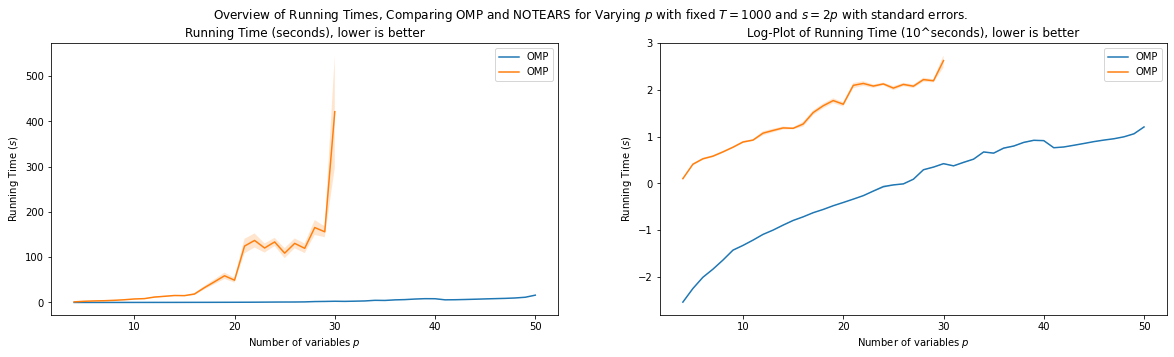

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (20, 5))
fig.suptitle("Overview of Running Times, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = 2p$ with standard errors.")
titles = ['Running Time (seconds), lower is better', 'Log-Plot of Running Time (10^seconds), lower is better']

axs[0].plot(Ps_OMP, OMP_means[:, 0], label = "OMP")
axs[0].fill_between(Ps_OMP, OMP_means[:, 0] - OMP_ses[:, 0], OMP_means[:, 0] + OMP_ses[:, 0], alpha = 0.2)

axs[0].plot(Ps_NT, NT_means[:, 0], label = "OMP")
axs[0].fill_between(Ps_NT, NT_means[:, 0] - NT_ses[:, 0], NT_means[:, 0] + NT_ses[:, 0], alpha = 0.2)

axs[1].plot(Ps_OMP, np.log10(OMP_means[:, 0]), label = "OMP")
axs[1].fill_between(Ps_OMP, np.log10(OMP_means[:, 0] - OMP_ses[:, 0]), np.log10(OMP_means[:, 0] + OMP_ses[:, 0]), alpha = 0.2)

axs[1].plot(Ps_NT, np.log10(NT_means[:, 0]), label = "OMP")
axs[1].fill_between(Ps_NT, np.log10(NT_means[:, 0] - NT_ses[:, 0]), np.log10(NT_means[:, 0] + NT_ses[:, 0]), alpha = 0.2)

for i in range(2):
    axs[i].set_title(titles[i])
    axs[i].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='Running Time ($s$)')

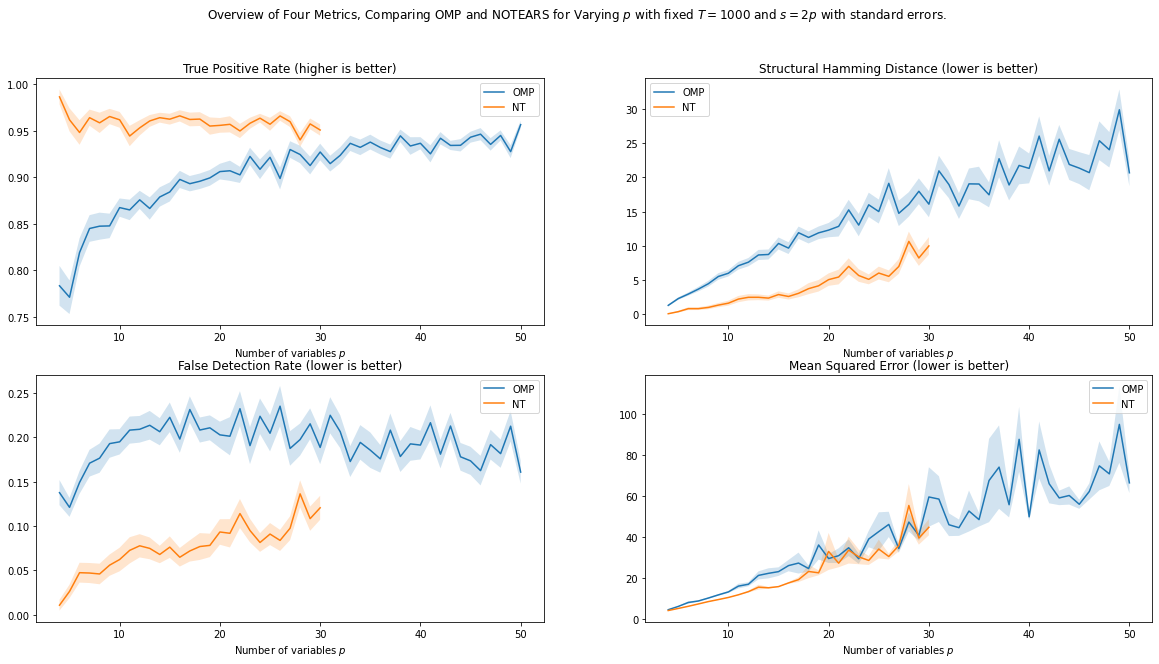

In [30]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle("Overview of Four Metrics, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = 2p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Detection Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'Mean Squared Error (lower is better)']

for i in range(0, 4):
    axs[i % 2, i // 2].plot(Ps_OMP, OMP_means[:, i + 1], label = "OMP")
    axs[i % 2, i // 2].fill_between(Ps_OMP, OMP_means[:, i + 1] - OMP_ses[:, i + 1], OMP_means[:, i + 1] + OMP_ses[:, i + 1], alpha = 0.2)

    axs[i % 2, i // 2].plot(Ps_NT, NT_means[:, i + 1], label = "NT")
    axs[i % 2, i // 2].fill_between(Ps_NT, NT_means[:, i + 1] - NT_ses[:, i + 1], NT_means[:, i + 1] + NT_ses[:, i + 1], alpha = 0.2)
    
    axs[i % 2, i // 2].set_title(titles[i])
    
    axs[i % 2, i // 2].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10))
fig.suptitle("Overview of Four Metrics, Comparing OMP and NOTEARS for Varying $p$ with fixed $T = 1000$ and $s = p$ with standard errors.")
titles = ['True Positive Rate (higher is better)', 'False Detection Rate (lower is better)', 'Structural Hamming Distance (lower is better)', 'Mean Squared Error (lower is better)']

for i in range(4):
    axs[i % 2, i // 2].plot(Ps, np.mean(np.array(r_OMP)[:, i + 1], axis = 1), label = "OMP")
    axs[i % 2, i // 2].fill_between(Ps, np.mean(np.array(r_OMP)[:, i + 1], axis = 1) - scistats.sem(np.array(r_OMP)[:, i + 1], axis = 1), np.mean(np.array(r_OMP)[:, i + 1], axis = 1) + scistats.sem(np.array(r_OMP)[:, i + 1], axis = 1), alpha = 0.2)

#     axs[i % 2, i // 2].plot(Ps, np.mean(np.array(r_NT)[:, i + 1], axis = 1), label = "NOTEARS")
#     axs[i % 2, i // 2].fill_between(Ps, np.mean(np.array(r_NT)[:, i + 1], axis = 1) - scistats.sem(np.array(r_NT)[:, i + 1], axis = 1), np.mean(np.array(r_NT)[:, i + 1], axis = 1) + scistats.sem(np.array(r_NT)[:, i + 1], axis = 1), alpha = 0.2)
    
    axs[i % 2, i // 2].set_title(titles[i])
    
    axs[i % 2, i // 2].legend()
    
for ax in axs.flat:
    ax.set(xlabel='Number of variables $p$', ylabel='')